# GAN com *MNIST*


In [3]:
# Importando os módulos necessários
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [1]:
def get_dl(batchsize):
    """
    Define uma transformação para converter os dados em Tensores,
    baixa os dados de treino e teste do MNIST e os transforma em Tensores.
    Cria objetos DataLoader para carregar eficientemente os dados em lotes.
    """
    train_transforms = transforms.Compose([transforms.ToTensor()])

    train_data = MNIST(root="./train.", train=True, download=True, transform=train_transforms)
    test_data = MNIST(root="./test.", train=True, download=True, transform=train_transforms)

    train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [4]:
class Generator(nn.Module):
    def __init__(self, batch_size, input_dim):
        super().__init__()
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, 128)
        self.LRelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 1 * 28 * 28)
        self.tanH = nn.Tanh()

    def forward(self, x):
        layer1 = self.LRelu(self.fc1(x))
        layer2 = self.tanH(self.fc2(layer1))
        out = layer2.view(self.batch_size, 1, 28, 28)
        return out

In [5]:
class Discriminator(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.fc1 = nn.Linear(1 * 28 * 28, 128)
        self.LReLu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 1)
        self.SigmoidL = nn.Sigmoid()

    def forward(self, x):
        flat = x.view(self.batch_size, -1)
        layer1 = self.LReLu(self.fc1(flat))
        out = self.SigmoidL(self.fc2(layer1))
        return out.view(-1, 1).squeeze(1)

In [15]:
def get_dl(batchsize):
    """
    Define uma transformação para converter os dados em Tensores e normalizá-los
    para o intervalo [-1, 1]. Baixa os dados de treino e teste do MNIST
    e cria os DataLoaders.
    """
    # Define as transformações
    train_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) # Normaliza de [0, 1] para [-1, 1]
    ])

    # Baixa e prepara os datasets
    train_data = MNIST(root="./train.", train=True, download=True, transform=train_transforms)
    test_data = MNIST(root="./test.", train=True, download=True, transform=train_transforms)

    # Cria os DataLoaders
    train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [6]:
def train_model(no_of_epochs, disc, gen, optimD, optimG, dataloaders, loss_fn, input_size, batch_size):
    """
    Treina um modelo GAN e retorna o histórico de perdas.
    """
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Listas para armazenar as perdas
    G_losses = []
    D_losses = []

    reall = 1
    fakel = 0

    num_batches = len(dataloaders['train'])

    for epoch in range(no_of_epochs):
        print('Época {}/{}'.format(epoch + 1, no_of_epochs))
        running_loss_D = 0
        running_loss_G = 0

        for inputs, _ in dataloaders['train']:
            inputs = inputs.to(device)
            real_label = torch.full((batch_size,), reall, dtype=inputs.dtype, device=device)
            fake_label = torch.full((batch_size,), fakel, dtype=inputs.dtype, device=device)

            # --- Treinamento do Discriminador ---
            optimD.zero_grad()
            output = disc(inputs)
            D_real_loss = loss_fn(output, real_label)
            D_real_loss.backward()

            noise = torch.randn(batch_size, input_size, device=device)
            fake = gen(noise)
            output = disc(fake.detach())
            D_fake_loss = loss_fn(output, fake_label)
            D_fake_loss.backward()

            Disc_loss = D_real_loss + D_fake_loss
            running_loss_D += Disc_loss.item()
            optimD.step()

            # --- Treinamento do Gerador ---
            optimG.zero_grad()
            output = disc(fake)
            Gen_loss = loss_fn(output, real_label)
            running_loss_G += Gen_loss.item()
            Gen_loss.backward()
            optimG.step()

        # Calcula a perda média e armazena
        avg_loss_D = running_loss_D / num_batches
        avg_loss_G = running_loss_G / num_batches
        D_losses.append(avg_loss_D)
        G_losses.append(avg_loss_G)

        print("Perda do Discriminador : {:.4f}".format(avg_loss_D))
        print("Perda do Gerador : {:.4f}".format(avg_loss_G))

    return G_losses, D_losses

In [7]:
def plot_metrics(g_losses, d_losses):
    """
    Plota as perdas do Gerador e do Discriminador ao longo das épocas.
    """
    plt.figure(figsize=(10, 5))
    plt.title("Perdas do Gerador e Discriminador Durante o Treinamento")
    plt.plot(g_losses, label="Perda do Gerador (G)")
    plt.plot(d_losses, label="Perda do Discriminador (D)")
    plt.xlabel("Épocas")
    plt.ylabel("Perda")
    plt.legend()
    plt.show()

Época 1/50
Perda do Discriminador : 0.9302
Perda do Gerador : 0.8718
Época 2/50
Perda do Discriminador : 0.7550
Perda do Gerador : 1.2784
Época 3/50
Perda do Discriminador : 0.6626
Perda do Gerador : 1.5634
Época 4/50
Perda do Discriminador : 0.7021
Perda do Gerador : 1.5768
Época 5/50
Perda do Discriminador : 0.7511
Perda do Gerador : 1.5507
Época 6/50
Perda do Discriminador : 0.7298
Perda do Gerador : 1.6122
Época 7/50
Perda do Discriminador : 0.7192
Perda do Gerador : 1.7854
Época 8/50
Perda do Discriminador : 0.7765
Perda do Gerador : 1.7111
Época 9/50
Perda do Discriminador : 0.8304
Perda do Gerador : 1.5976
Época 10/50
Perda do Discriminador : 0.8460
Perda do Gerador : 1.5687
Época 11/50
Perda do Discriminador : 0.8598
Perda do Gerador : 1.5404
Época 12/50
Perda do Discriminador : 0.8126
Perda do Gerador : 1.6429
Época 13/50
Perda do Discriminador : 0.8135
Perda do Gerador : 1.6875
Época 14/50
Perda do Discriminador : 0.8480
Perda do Gerador : 1.6457
Época 15/50
Perda do Discrimi

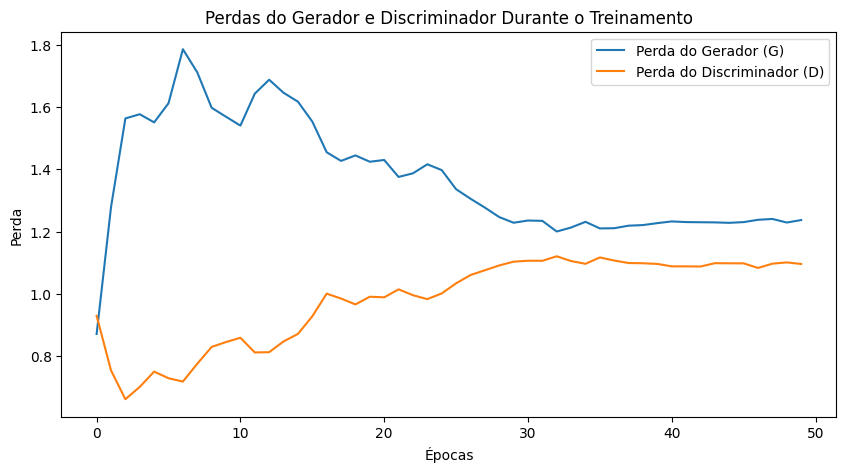

In [23]:
# --- Bloco de Execução Principal ---

torch.manual_seed(4)

# 1. Definição dos hiperparâmetros
batch_size = 64
no_of_epochs = 50  # Sugestão de aumento de épocas
input_size = 100

# 2. AQUI você chama a função get_dl()
train_loader, test_loader = get_dl(batch_size)

# 3. Organização dos dados para a função de treino
dl = {}
dl['train'] = train_loader
dl['valid'] = test_loader

# Criação dos modelos, otimizadores e função de perda...
disc = Discriminator(batch_size)
gen = Generator(batch_size, input_size)

optimD = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))

loss_fn = torch.nn.BCELoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
disc.to(device)
gen.to(device)

# 4. O dicionário 'dl' (que contém os dados da função get_dl) é usado aqui
g_losses, d_losses = train_model(no_of_epochs, disc, gen, optimD, optimG, dl, loss_fn, input_size, batch_size)

# Plotagem das métricas
plot_metrics(g_losses, d_losses)

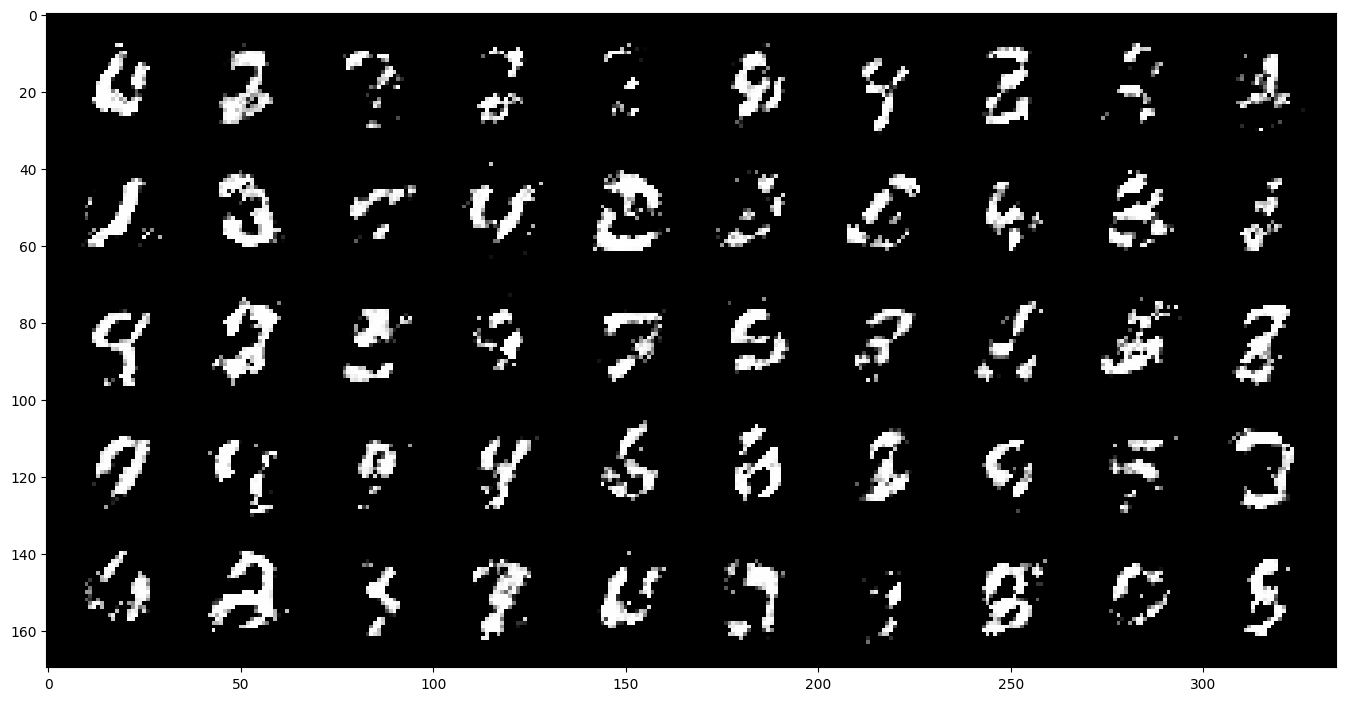

In [22]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

random_noise = torch.randn(128, input_size, device=device)

fake = gen(random_noise)
fake = fake.cpu()

fig, ax = plt.subplots(figsize=(20, 8.5))

show_image(torchvision.utils.make_grid(fake[0:50], 10, 5))
plt.show()